In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from pysolar.solar import get_altitude, radiation

from clearml import Task
from clearml import Dataset

from sklearn import linear_model

from amplify.DataGeneration import DataGenerator

In [2]:
# Constants 
BUILDING_LAT = 39.9649 
BUILDING_LON = -75.1396 

In [3]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="power-ss-notebook")

ClearML Task: created new task id=ddaf06daf3884333b02b72c4f6742adb
2022-01-23 15:28:31,488 - clearml.Task - WARNING - Failed auto-detecting task repository: Script file ['ipykernel_launcher', '/var/folders/14/343hdqps63j446zd_0kxgvwm0000gn/T/ipykernel_94974/1295558574.py'] could not be found
ClearML results page: http://10.0.0.8:80/projects/7542daf13d154039a6acfa6aa97d9ba0/experiments/ddaf06daf3884333b02b72c4f6742adb/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [4]:
# DataGenerator - ClearML
data_generator = DataGenerator()
# LoadData - ClearML
load_success, building_data, weather_data = data_generator.LoadData()

Info: Successfully loaded building data!


/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

overflow encountered in exp

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

invalid value encountered in multiply

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

overflow encountered in exp

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

invalid value encountered in multiply

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

overflow encountered in exp

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.py:50: RuntimeWarning:

invalid value encountered in multiply

/Users/samsipe/opt/miniconda3/envs/fourthbrain/lib/python3.8/site-packages/pysolar/radiation.p

Info: Successfully loaded weather data!


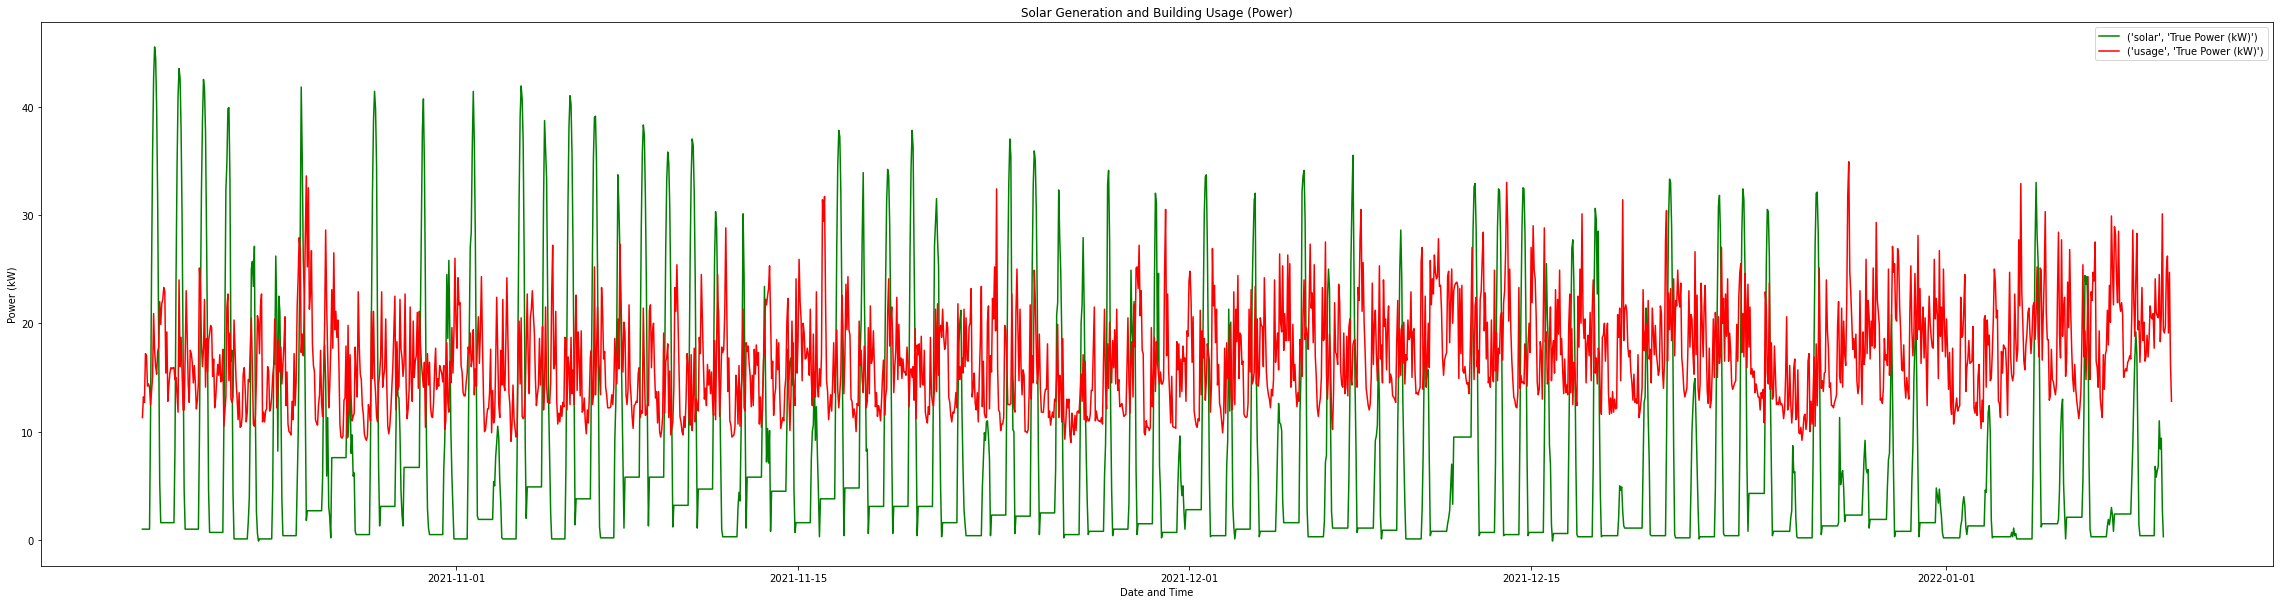

In [5]:
# Plot Power - Solar Gen vs Building Usage
fig, ax = plt.subplots(figsize=(40, 10))
plt.title('Solar Generation and Building Usage (Power)')

ax.plot(building_data.solar['True Power (kW)'], color='g')
ax.plot(building_data.usage['True Power (kW)'], color='r')

ax.set_xlabel('Date and Time')
ax.set_ylabel('Power (kW)')
plt.legend(building_data.columns)
plt.show()

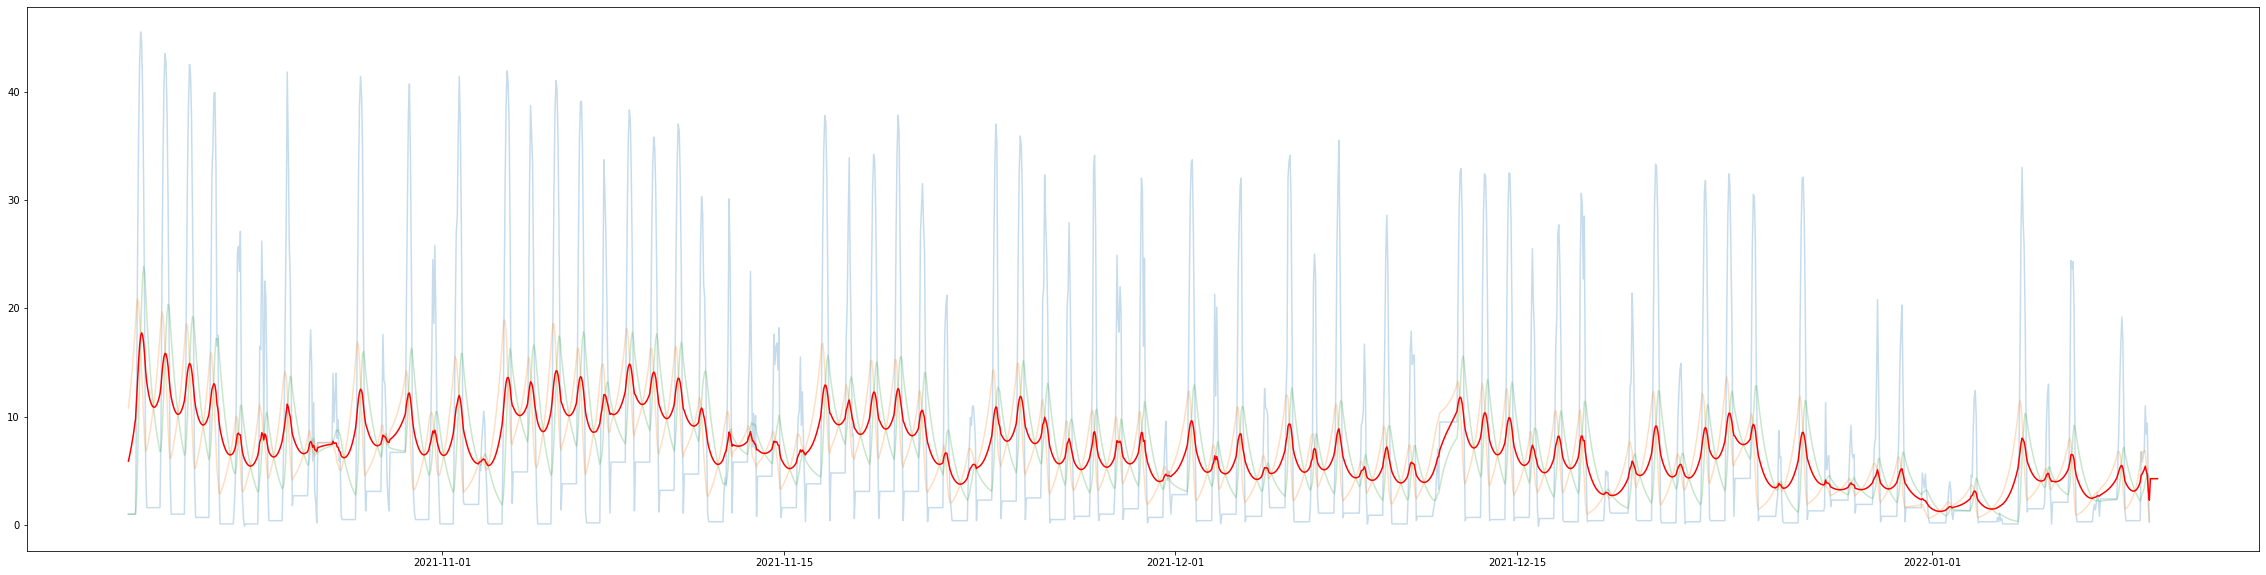

In [6]:
# Reversed-Recombined EWMA for improved accuracy
ewm = pd.DataFrame()                                                               # To collect data
ewm['fwd'] = building_data.solar['True Power (kW)'].ewm(span=24).mean()            # Calc forward EWMA
ewm['bwd'] = building_data.solar['True Power (kW)'][::-1].ewm(span=24).mean()      # Calc reversed EWMA

ewm['combo'] = ewm.mean(axis=1)                                                    # Reversed-Recombined EWMA

# Plotting
plt.figure(figsize=(40, 10))
plt.plot(building_data.solar['True Power (kW)'], alpha=0.25)
plt.plot(ewm.fwd, alpha=0.25)
plt.plot(ewm.bwd, alpha=0.25)
plt.plot(ewm.combo, color='r')

plt.show()

In [7]:
# Set date to split train/test at
split_date = pd.to_datetime('2022-01-01', utc=True)

# Test / Train split based on chosen split_date
weather_train = weather_data[weather_data.index <= split_date][1:]
ewm_train = ewm[ewm.index <= split_date]

weather_test = weather_data[(weather_data.index > split_date)]
ewm_test = ewm[ewm.index > split_date]

# On to the regression:
clf = linear_model.LinearRegression()
clf.fit(weather_train, ewm_train)

print(clf.coef_)

ewm_solar_pred = clf.predict(weather_test)

[[-0.18981908 -0.01155137  0.01007796  0.01437323  0.          0.00563556]
 [-0.27724794  0.03399143  0.0621158   0.00469733  0.         -0.00253063]
 [-0.23353351  0.01122003  0.03609688  0.00953528  0.          0.00155246]]


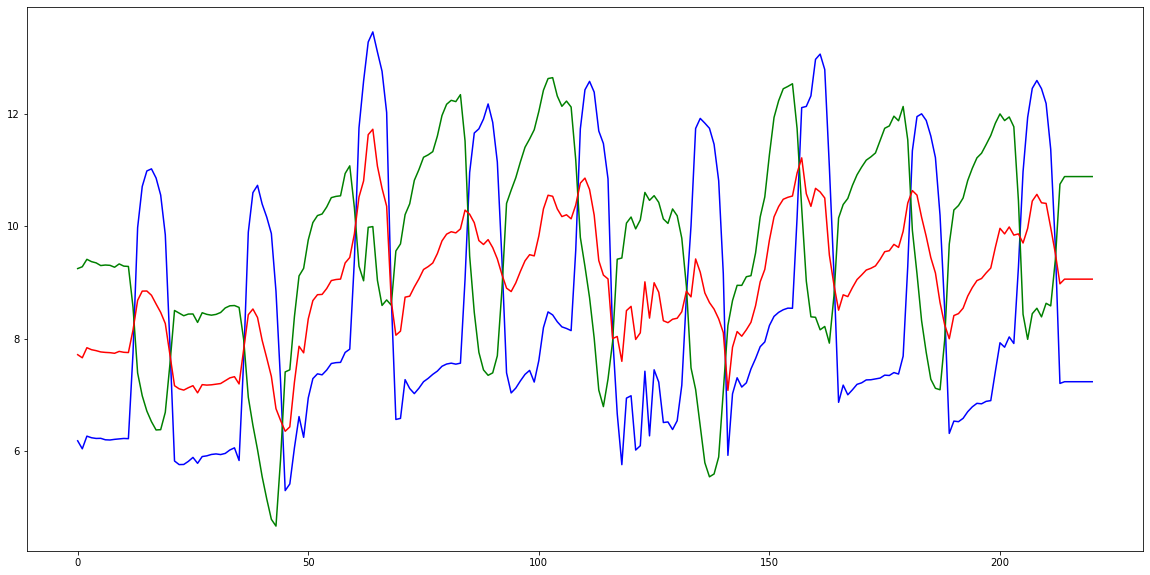

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(ewm_solar_pred[:, 0], color='b', label='Fwd')
plt.plot(ewm_solar_pred[:, 1], color='g', label='Bwd')
plt.plot(ewm_solar_pred[:, 2], color='r', label='Combo')

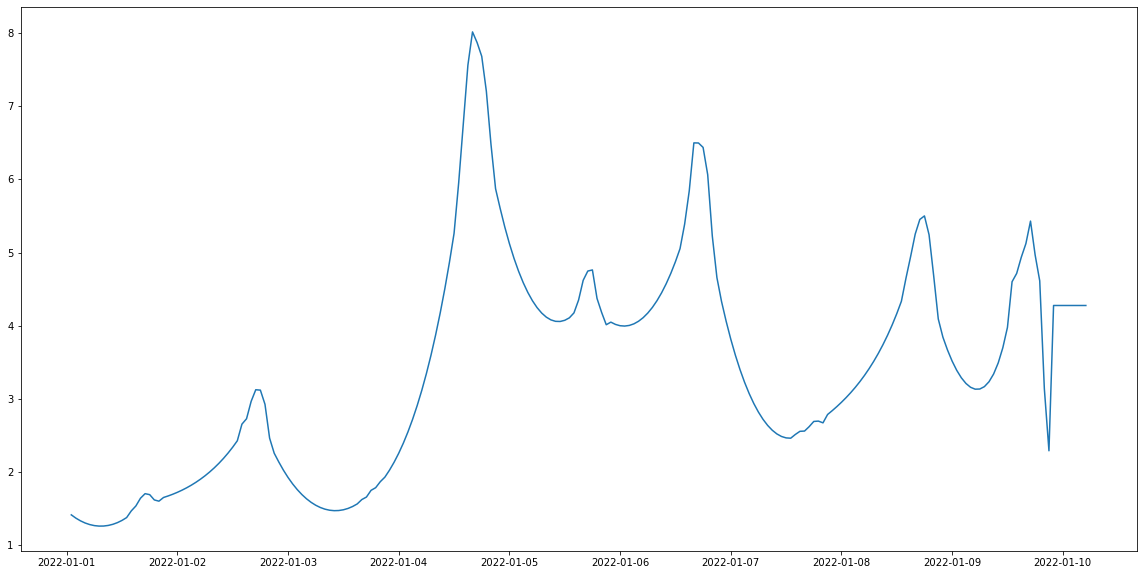

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(ewm_test.combo)